### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
#%matplotlib widget
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df
df sorted by tus
2019-02-06 03:49:28.525262
first tus:  -707119.0833333334 | max tus:  1302732.5833333333
24300
tus array OK ...


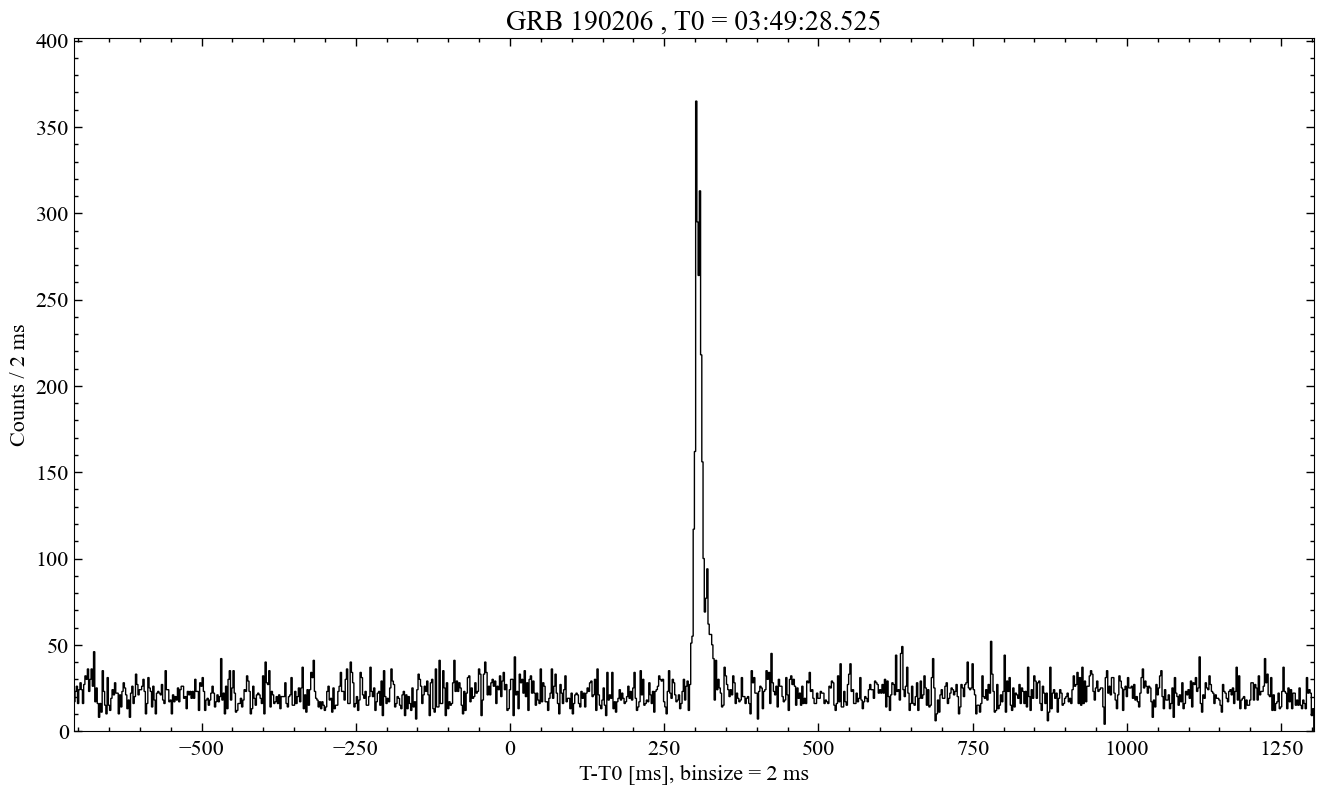

In [2]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB190206",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

0.512


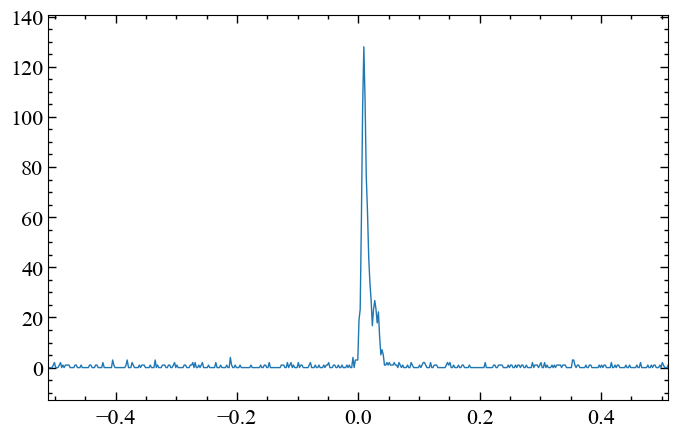

In [3]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002


kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# CrossCorr debugg

## Filter tus arr by keV [350-1500]

In [4]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 350<=kev<=1500:
        indexInBound.append(i)
print(len(indexInBound))
kevArr = kevArr[indexInBound]
print(len(tus))
tus = tus[indexInBound]
print(len(kevArr),len(tus))

11721
24300
11721 11721


In [5]:
laggApprox = -0.25
tus += laggApprox
hist = plt.hist(tus,bins=kw_bin_lo,align="left",histtype="step")
asimCounts,asimEdges = hist[0],hist[1]
asimLC = LC(time=asimEdges[:-1] + binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)# +binsize/2 because we want the correct bin_lo edges

In [6]:
#from here the lag is approx -0.05s
#produces a tshift=-0.044s, with kwLC as lc1 and asimLC as lc2

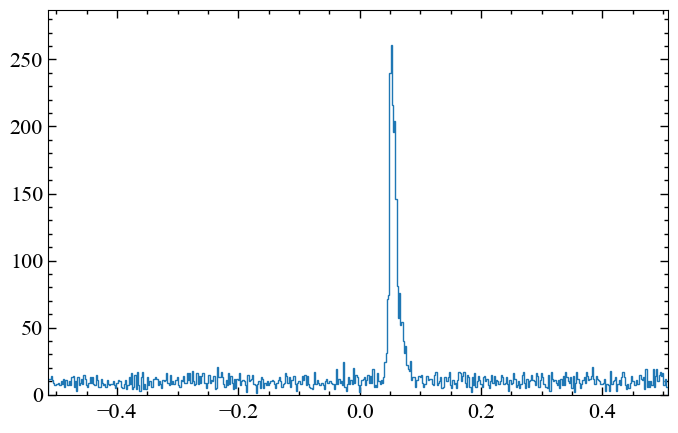

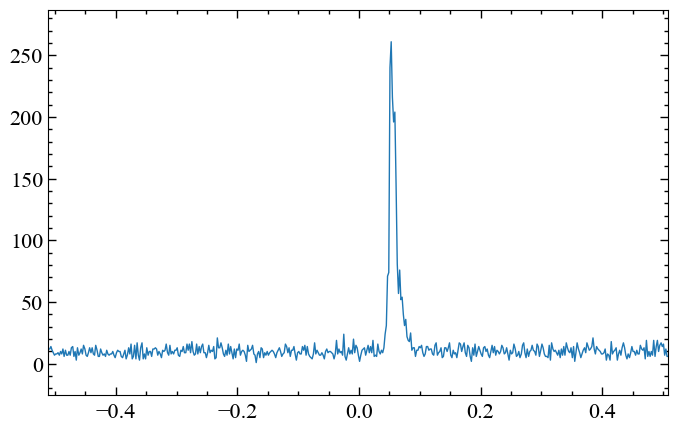

In [7]:

asimLC.plot()

Total lagg (s):  -0.294 | CC lagg:  -0.044


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


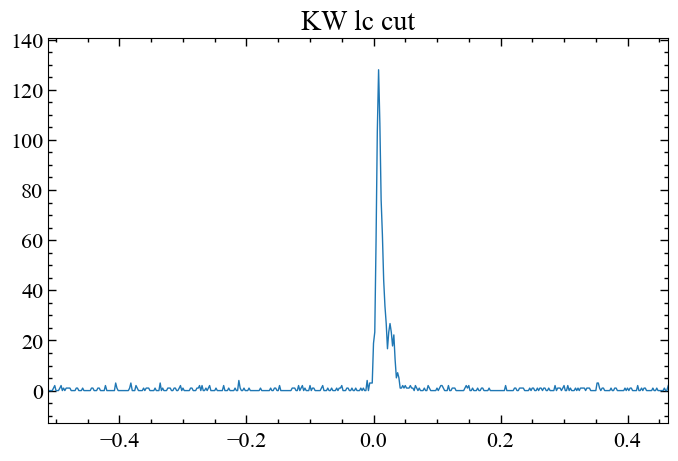

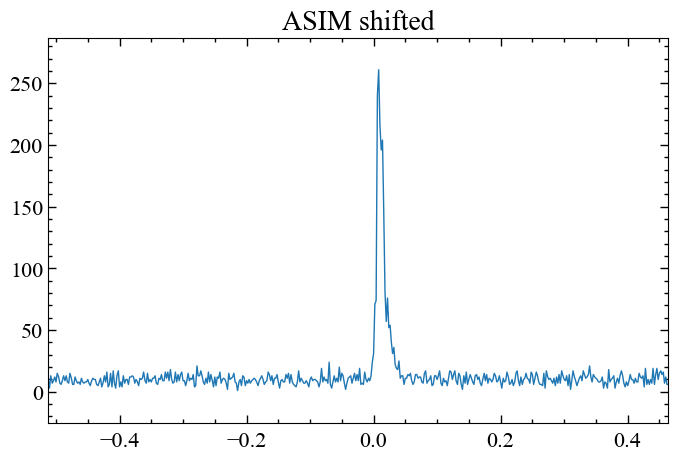

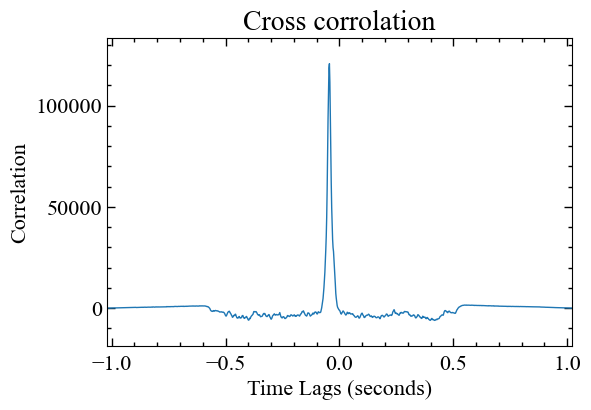

<AxesSubplot:title={'center':'Cross corrolation'}, xlabel='Time Lags (seconds)', ylabel='Correlation'>

In [8]:
CC = CrossCorrelation(kw_lc,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = CClagg + laggApprox
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
asimShiftLC = asimLC.shift(CClagg)
#have to make sure the two lightcurves start at the same time and end at the same time

def CompareLC(kw_lc=None,asimShiftLC=None):
    if kw_lc.bin_lo[0]>asimShiftLC.bin_lo[0]:
        i = find_nearest(asimShiftLC.bin_lo,kw_lc.bin_lo[0])
        if kw_lc.bin_lo[-1]>asimShiftLC.bin_lo[-1]:
            j = find_nearest(kw_lc.bin_lo,asimShiftLC.bin_lo[-1])
            kwCompare = LC(time=kw_lc.bin_lo[:j+1],counts=kw_lc.counts[:j+1])
            asimCompare = LC(time=asimShiftLC.bin_lo[i:],counts=asimShiftLC.counts[i:])
        else:
            j = find_nearest(asimShiftLC.bin_lo,kw_lc.bin_lo[-1])
            kwCompare = LC(time=kw_lc.bin_lo,counts=kw_lc.counts)
            asimCompare = LC(time=asimShiftLC.bin_lo[i:j+1],counts=asimShiftLC.counts[i:j+1])
    else:
        i = find_nearest(kw_lc.bin_lo,asimShiftLC.bin_lo[0])
        if kw_lc.bin_lo[-1]>asimShiftLC.bin_lo[-1]:
            j = find_nearest(kw_lc.bin_lo,asimShiftLC.bin_lo[-1])

            kwCompare = LC(time=kw_lc.bin_lo[:j+1],counts=kw_lc.counts[:j+1])
            asimCompare = LC(time=asimShiftLC.bin_lo,counts=asimShiftLC.counts)
        else:
            j = find_nearest(asimShiftLC.bin_lo,kw_lc.bin_lo[-1])
            kwCompare = LC(time=kw_lc.bin_lo[i:],counts=kw_lc.counts[:j+1])
            asimCompare = LC(time=asimShiftLC.bin_lo[:j+1],counts=asimShiftLC.counts[:j+1])
    return kwCompare,asimCompare
        
kwCompare.plot(title="KW lc cut")
#asimShiftLC.plot(title="ASIM shifted by {} s".format(tlagg))
asimCompare.plot(title="ASIM shifted")
#CC.plot(labels=['Time Lags (seconds)','Correlation'],title="Cross corrolation of ASIM and KW LC",save=True,filename="/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB190206A")
CC.plot(title="Cross corrolation",labels=['Time Lags (seconds)','Correlation'])


### Checking if CC is correct

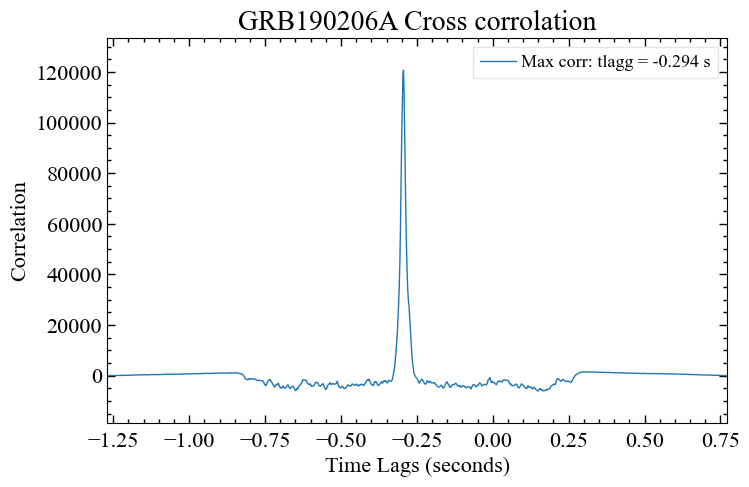

In [50]:
plt.plot(CC.time_lags+laggApprox,CC.corr,label="Max corr: tlagg = -0.294 s")
plt.title("GRB190206A Cross corrolation")
plt.xlabel('Time Lags (seconds)')
plt.ylabel('Correlation')
plt.legend()
plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB190206A/CC.png")
plt.show()

In [48]:
laggApprox,tlagg

(-0.25, -0.294)

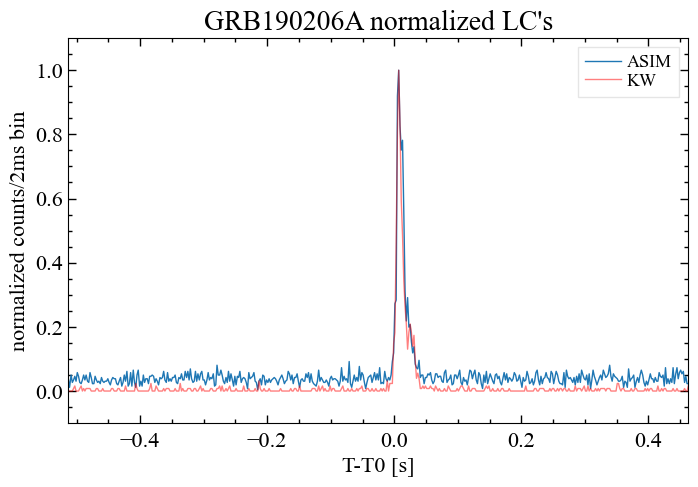

In [45]:

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare.counts),label="ASIM")
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare.counts),c="r",alpha=0.5,label="KW")
plt.legend()
plt.title("GRB190206A normalized LC's")
plt.xlabel("T-T0 [s]")
plt.ylabel("normalized counts/2ms bin")
#plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB190206A/overlappingLC.png")
plt.show()


In [31]:
ASIM_df["tus"] = ASIM_df["tus"].to_numpy() + tlagg*1e6
shiftedTus = ASIM_df["tus"].to_numpy()

tus array OK ...


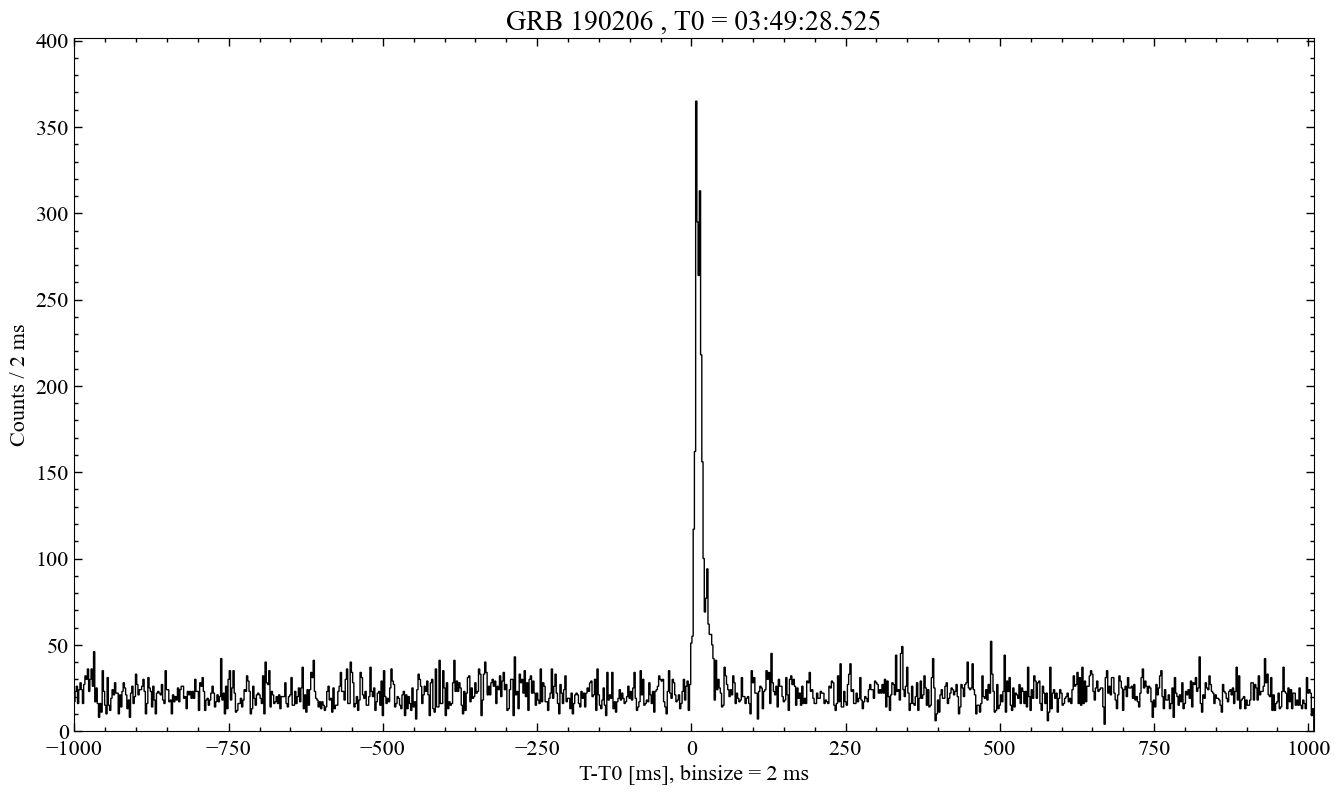

In [39]:
plot_HED(tus_arr=shiftedTus,T0=T0_ASIM,binsize=2)

In [42]:
event_interval = (0,0.064)
bak_interval = (-0.9,-0.05)
#time unit is seconds!
keV_df = keV_hist(df=ASIM_df,time_interval=bak_interval,
                 keV_interval="max",
                 duration=0.95,
                 )
#All triggers in the time_interval are kept

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  9204
n triggers are within bounds  9204
keV bins are set for HED
Energies binned!


In [44]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB190206A/ASIM_data/HED_bak.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [43]:
keV_df

,bins_keV,counts,poisson_error_counts,duration_seconds
0,1.000000E+01,-9.999000E+03,-9.999000E+03,-9.999000E+03
1,1.258925E+01,0.000000E+00,0.000000E+00,9.500000E-01
2,1.584893E+01,0.000000E+00,0.000000E+00,9.500000E-01
3,1.995262E+01,0.000000E+00,0.000000E+00,9.500000E-01
4,2.511886E+01,0.000000E+00,0.000000E+00,9.500000E-01
5,3.162278E+01,0.000000E+00,0.000000E+00,9.500000E-01
6,3.981072E+01,0.000000E+00,0.000000E+00,9.500000E-01
7,5.011872E+01,0.000000E+00,0.000000E+00,9.500000E-01
8,6.309573E+01,0.000000E+00,0.000000E+00,9.500000E-01
9,7.943282E+01,0.000000E+00,0.000000E+00,9.500000E-01
